# 0. Project definition -- > "Software Release Planning as an Intelligent Agent Problem"

In [ ]:
# I formulate software release planning as a constrained 0–1 optimization problem over feature subsets.
# Because the search space is exponential in the number of features and includes complex constraints, I use a Genetic Algorithm —
# a evolutionary method — to efficiently search for high-fitness release plans.
# The fitness function encodes domain knowledge about capacity, must-haves features, dependencies, and
# business value via a weighted benefit-minus-penalty scheme.

# 1. Imports & config constants

In [ ]:
import os
import random
from dataclasses import dataclass
from typing import List, Dict
import pandas as pd


## Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/Colab Notebooks/SCS_3547_Intelligent Agents/3547_Intelligent Agents Project"


Mounted at /content/drive


In [ ]:
EXCEL_PATH = os.path.join(base_path, "release_planning_backlog.xlsx")
print(EXCEL_PATH)

# Raw load for inspection (optional but nice to verify)
df_backlog = pd.read_excel(EXCEL_PATH)

print("Backlog shape:", df_backlog.shape)
df_backlog.head()

/content/drive/MyDrive/Colab Notebooks/SCS_3547_Intelligent Agents/3547_Intelligent Agents Project/release_planning_backlog.xlsx
Backlog shape: (30, 8)


,id,title,category,effort,business_value,must_have,strategic_flag,dependencies
0,F01,Encrypt configuration backups and disable plai...,Security & Compliance,5,9,1,1,[]
1,F02,Improve session dashboard load time for large ...,Reliability & Performance,3,7,0,0,[]
2,F03,Introduce zero-trust access policy engine for ...,Security & Compliance,5,9,1,1,[]
3,F04,Add quick-connect bookmarks for frequently acc...,Usability & UX,2,8,0,0,[]
4,F05,Normalize Crossbow asset IDs with PowerBase eq...,Integrations & Data,5,9,1,1,[]


## Configuration parameters

In [ ]:
# === Problem configuration ===
# Maximum development team total effort (e.g., story points) that the team can handle in this release.
# This is the capacity constraint for the Genetic Algorithm (GA) and greedy baselines.
TEAM_CAPACITY: int = 50


# === Fitness function weights ===
# Penalty weight for missing must-have features.
# Larger value => GA is strongly discouraged from dropping must-haves.
W_MUST_HAVE: float = 2.0

# Penalty weight for exceeding team capacity.
# Smaller than W_MUST_HAVE because, from a business perspective,
# missing must-haves is worse than slightly overfilling capacity.
W_CAPACITY: float = 1.0


# === Genetic Algorithm hyperparameters ===
# Number of individuals (candidate release plans) in the population.
POP_SIZE: int = 80

# Number of generations (iterations) for the evolutionary loop.
N_GENERATIONS: int = 150

# Tournament size used in tournament selection:
# how many individuals compete when selecting a parent.
TOURNAMENT_SIZE: int = 3

# Probability of applying crossover when producing a pair of children.
CROSSOVER_RATE: float = 0.8

# Probability of flipping each bit during mutation.
MUTATION_RATE: float = 0.02

# Random seed for reproducibility of results.
RANDOM_SEED: int = 42



# 2. Feature dataclass and backlog loading

In [ ]:
# === Data model for backlog items ===
from ast import literal_eval  # For safely parsing the dependencies list from string


@dataclass
class Feature:
    """
    Represents a single backlog item (feature) that can be included in a release.

    Attributes:
        id: Short identifier of the feature, e.g. "F01".
        title: Human-readable description of the feature.
        category: High-level category (Security, UX, Integrations, etc.).
        effort: Estimated implementation effort (e.g., story points).
        business_value: Business value score (1–10), higher is better.
        must_have: 1 if this is a must-have feature for the release, else 0.
        strategic_flag: 1 if this is strategically important (e.g., key customer, regulatory), else 0.
        dependencies: List of feature IDs that must be included if this feature is selected.
    """
    id: str
    title: str
    category: str
    effort: int
    business_value: int
    must_have: int
    strategic_flag: int
    dependencies: List[str]


def _parse_dependencies(cell_value) -> List[str]:
    """
    Helper to parse the 'dependencies' cell from the Excel file.

    The Excel file stores dependencies as a string, e.g.:
      "[]"
      "["F03"]"
      "["F03", "F05"]"

    This function converts that string into a Python list of strings.
    If the cell is empty or cannot be parsed, it returns an empty list.
    """
    if isinstance(cell_value, str):
        text = cell_value.strip()
        if not text:
            return []
        try:
            # Safely evaluate string representation of a Python list
            deps = literal_eval(text)
            # Ensure we always return a list of strings
            if isinstance(deps, list):
                return [str(d).strip() for d in deps]
            else:
                # If it's a single value (rare), wrap it into a list
                return [str(deps).strip()]
        except (SyntaxError, ValueError):
            # Fallback: split by comma if it's not valid Python list syntax
            return [part.strip() for part in text.split(",") if part.strip()]
    else:
        # NaN or other non-string → treat as no dependencies
        return []


def load_backlog_from_excel(path: str) -> List[Feature]:
    """
    Load the release backlog from an Excel file into a list of Feature objects.

    The Excel file is expected to have the following columns:
        id, title, category, effort, business_value,
        must_have, strategic_flag, dependencies

    Returns:
        A list of Feature instances. The order of rows in the Excel file
        defines the order of features and thus the bit positions in the GA chromosome.
    """
    df = pd.read_excel(path)

    features: List[Feature] = []
    for _, row in df.iterrows():
        dependencies = _parse_dependencies(row.get("dependencies", ""))

        feature = Feature(
            id=str(row["id"]),
            title=str(row["title"]),
            category=str(row["category"]),
            effort=int(row["effort"]),
            business_value=int(row["business_value"]),
            must_have=int(row["must_have"]),
            strategic_flag=int(row["strategic_flag"]),
            dependencies=dependencies,
        )
        features.append(feature)

    return features


In [ ]:
# Sanity check
backlog = load_backlog_from_excel(EXCEL_PATH)

print(f"Loaded {len(backlog)} features")
backlog[0]

Loaded 30 features


Feature(id='F01', title='Encrypt configuration backups and disable plaintext exports', category='Security & Compliance', effort=5, business_value=9, must_have=1, strategic_flag=1, dependencies=[])

# 3. Representation helpers (individual encode/decode)

In [ ]:
# === Individual (release plan) representation helpers ===

def individual_length(backlog: List[Feature]) -> int:
    """
    Return the number of features in the backlog.
    This is also the length of the chromosome (0/1 list).
    """
    return len(backlog)


def random_individual(n_features: int, p_select: float = 0.4) -> List[int]:
    """
    Create a random individual (candidate release plan).

    Args:
        n_features: Number of features in the backlog.
        p_select: Probability of including a given feature (bit=1).
                  A value < 0.5 biases initial plans towards smaller scope.

    Returns:
        A list of 0/1 integers, where 1 means "include this feature in the release".
    """
    return [1 if random.random() < p_select else 0 for _ in range(n_features)]


def decode_individual(individual: List[int], backlog: List[Feature]) -> List[Feature]:
    """
    Convert a 0/1 chromosome into the corresponding list of selected Feature objects.
    """
    return [feature for bit, feature in zip(individual, backlog) if bit == 1]


In [ ]:
# Sanity Check
n = individual_length(backlog)
ind = random_individual(n)
len(ind), sum(ind), decode_individual(ind, backlog)[:3]


(30,
 8,
 [Feature(id='F01', title='Encrypt configuration backups and disable plaintext exports', category='Security & Compliance', effort=5, business_value=9, must_have=1, strategic_flag=1, dependencies=[]),
  Feature(id='F03', title='Introduce zero-trust access policy engine for field IEDs', category='Security & Compliance', effort=5, business_value=9, must_have=1, strategic_flag=1, dependencies=[]),
  Feature(id='F05', title='Normalize Crossbow asset IDs with PowerBase equipment model', category='Integrations & Data', effort=5, business_value=9, must_have=1, strategic_flag=1, dependencies=[])])

# 4. Fitness & constraint helpers

In [ ]:
# === Fitness function and supporting helpers ===

def compute_total_effort(individual: List[int], backlog: List[Feature]) -> int:
    """Total effort of all features selected in this individual."""
    return sum(bit * f.effort for bit, f in zip(individual, backlog))


def compute_total_value(individual: List[int], backlog: List[Feature]) -> int:
    """Total business value of all features selected in this individual."""
    return sum(bit * f.business_value for bit, f in zip(individual, backlog))


def compute_missing_must_haves(individual: List[int], backlog: List[Feature]) -> int:
    """
    Count how many must-have features are NOT selected in this individual.
    """
    missing = 0
    for bit, f in zip(individual, backlog):
        if f.must_have == 1 and bit == 0:
            missing += 1
    return missing


def compute_over_capacity(total_effort: int, capacity: int) -> int:
    """
    How many effort units over the capacity this plan is.
    Returns 0 if within capacity.
    """
    return max(0, total_effort - capacity)


def compute_fitness(individual: List[int], backlog: List[Feature], capacity: int) -> float:
    """
    Compute fitness for a given individual (release plan).

    Higher fitness is better.

    Components:
        - ValueScore: normalized total business value in [0, 1]
        - Must-have penalty: normalized missing must-haves, weighted by W_MUST_HAVE
        - Capacity penalty: normalized over-capacity, weighted by W_CAPACITY

    fitness = value_score - W_MUST_HAVE * must_penalty - W_CAPACITY * cap_penalty
    """
    # --- Value component ---
    total_value = compute_total_value(individual, backlog)
    # Maximum possible value is the sum of values of all features
    max_possible_value = sum(f.business_value for f in backlog)
    if max_possible_value > 0:
        value_score = total_value / max_possible_value
    else:
        value_score = 0.0

    # --- Must-have penalty (0 if all must-haves selected, up to 1 if all missing) ---
    total_must_haves = sum(f.must_have for f in backlog)
    missing_must_haves = compute_missing_must_haves(individual, backlog)
    if total_must_haves > 0:
        must_penalty_norm = missing_must_haves / total_must_haves
    else:
        must_penalty_norm = 0.0

    # --- Capacity penalty (0 if within capacity, grows as we exceed it) ---
    total_effort = compute_total_effort(individual, backlog)
    over_cap = compute_over_capacity(total_effort, capacity)
    if capacity > 0:
        cap_penalty_norm = over_cap / capacity
    else:
        cap_penalty_norm = 0.0

    # --- Combine into overall fitness ---
    fitness = (
        value_score
        - W_MUST_HAVE * must_penalty_norm
        - W_CAPACITY * cap_penalty_norm
    )

    return fitness


In [ ]:
# Sanity check
n = individual_length(backlog)
ind = random_individual(n)
fit = compute_fitness(ind, backlog, TEAM_CAPACITY)

print("Random individual:")
print("  bits selected:", sum(ind), "out of", n)
print("  total effort:", compute_total_effort(ind, backlog))
print("  total value:", compute_total_value(ind, backlog))
print("  fitness:", fit)

Random individual:
  bits selected: 10 out of 30
  total effort: 55
  total value: 74
  fitness: -0.8904761904761903


# 5. GA operators (selection, crossover, mutation, init)

## 5.1 Population initialization

In [ ]:
# === GA operators: population initialization, selection, crossover, mutation ===

def initialize_population(pop_size: int, n_features: int, p_select: float = 0.4) -> List[List[int]]:
    """
    Initialize a population of random individuals (candidate release plans).

    Args:
        pop_size: Number of individuals in the population.
        n_features: Length of each chromosome (number of backlog items).
        p_select: Probability of including a given feature (bit=1) in the initial population.

    Returns:
        A list of individuals, each a list of 0/1 integers.
    """
    return [random_individual(n_features, p_select=p_select) for _ in range(pop_size)]


## 5.2 Tournament selection (survival of the fittest)

In [ ]:
def tournament_selection(
    population: List[List[int]],
    fitnesses: List[float],
    k: int
) -> List[int]:
    """
    Select one individual from the population using tournament selection.

    Args:
        population: List of individuals (chromosomes).
        fitnesses: List of fitness values aligned with the population.
        k: Tournament size (number of individuals competing).

    Returns:
        A *copy* of the selected individual.
    """
    # Randomly pick k distinct indices for the tournament
    indices = random.sample(range(len(population)), k)
    # Find the index with the best fitness among them
    best_index = indices[0]
    best_fitness = fitnesses[best_index]

    for idx in indices[1:]:
        if fitnesses[idx] > best_fitness:
            best_index = idx
            best_fitness = fitnesses[idx]

    # Return a copy so we don't accidentally modify the original in place
    return population[best_index].copy()


## 5.3 Crossover (one-point)

In [ ]:
def crossover_one_point(
    parent1: List[int],
    parent2: List[int],
    crossover_rate: float
) -> (List[int], List[int]):
    """
    One-point crossover between two parents.

    With probability `crossover_rate`, perform crossover at a random position.
    Otherwise, return (copies of) the original parents.

    Args:
        parent1, parent2: Parent chromosomes (same length).
        crossover_rate: Probability of applying crossover.

    Returns:
        Two child chromosomes (lists of ints).
    """
    n = len(parent1)
    # Safety check: very short chromosomes can't be meaningfully crossed
    if n < 2 or random.random() > crossover_rate:
        return parent1.copy(), parent2.copy()

    # Choose crossover point between 1 and n-1
    point = random.randint(1, n - 1)

    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]

    return child1, child2


## 5.4 Mutation (bit-flip)

In [ ]:
def mutate_bit_flip(individual: List[int], mutation_rate: float) -> List[int]:
    """
    Apply bit-flip mutation to an individual.

    For each gene (bit), with probability `mutation_rate`, flip 0 -> 1 or 1 -> 0.

    Args:
        individual: Chromosome to mutate.
        mutation_rate: Probability of flipping each bit.

    Returns:
        A *new* mutated individual (original is not modified).
    """
    mutated = individual.copy()
    for i in range(len(mutated)):
        if random.random() < mutation_rate:
            mutated[i] = 1 - mutated[i]  # flip bit
    return mutated


## 5.5 Sanity checks

In [ ]:
# Sanity check for GA operators
random.seed(RANDOM_SEED)

n = individual_length(backlog)
pop = initialize_population(POP_SIZE, n)

# Compute fitnesses for the initial population
fitnesses = [compute_fitness(ind, backlog, TEAM_CAPACITY) for ind in pop]

print("Initial population size:", len(pop))
print("Sample individual bits selected:", sum(pop[0]), "out of", n)
print("Sample individual fitness:", fitnesses[0])

Initial population size: 80
Sample individual bits selected: 15 out of 30
Sample individual fitness: -1.2771428571428571


In [ ]:
# Test tournament selection
parent = tournament_selection(pop, fitnesses, TOURNAMENT_SIZE)
print("Selected parent bits:", sum(parent))

Selected parent bits: 14


In [ ]:
# Test crossover and mutation
parent2 = tournament_selection(pop, fitnesses, TOURNAMENT_SIZE)
child1, child2 = crossover_one_point(parent, parent2, CROSSOVER_RATE)
mutated_child1 = mutate_bit_flip(child1, MUTATION_RATE)

print("Parent1 bits:", sum(parent))
print("Parent2 bits:", sum(parent2))
print("Child1 bits:", sum(child1))
print("Mutated child1 bits:", sum(mutated_child1))


Parent1 bits: 14
Parent2 bits: 14
Child1 bits: 14
Mutated child1 bits: 14


# 6. GA main loop (run_ga)

In [ ]:
# === GA main loop ===

def run_ga(backlog: List[Feature], capacity: int):
    """
    Run the Genetic Algorithm to search for a high-quality release plan.

    Returns:
        best_individual: The best chromosome found.
        best_fitness: Fitness of that chromosome.
        history_best: List of best fitness values per generation.
    """
    random.seed(RANDOM_SEED)

    n_features = individual_length(backlog)

    # --- Initialize population ---
    population = initialize_population(POP_SIZE, n_features)
    fitnesses = [compute_fitness(ind, backlog, capacity) for ind in population]

    # --- Track the best-so-far individual ---
    best_index = max(range(len(population)), key=lambda i: fitnesses[i])
    best_individual = population[best_index].copy()
    best_fitness = fitnesses[best_index]

    history_best = [best_fitness]

    # --- Evolutionary loop ---
    for gen in range(N_GENERATIONS):
        new_population: List[List[int]] = []

        # Elitism: carry over the best individual unchanged
        new_population.append(best_individual.copy())

        # Fill the rest of the new population
        while len(new_population) < POP_SIZE:
            # Parent selection
            parent1 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
            parent2 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)

            # Crossover
            child1, child2 = crossover_one_point(parent1, parent2, CROSSOVER_RATE)

            # Mutation
            child1 = mutate_bit_flip(child1, MUTATION_RATE)
            child2 = mutate_bit_flip(child2, MUTATION_RATE)

            # Add children to new population (with size check)
            new_population.append(child1)
            if len(new_population) < POP_SIZE:
                new_population.append(child2)

        # Replace old population
        population = new_population
        fitnesses = [compute_fitness(ind, backlog, capacity) for ind in population]

        # Update best-so-far
        current_best_index = max(range(len(population)), key=lambda i: fitnesses[i])
        current_best_fitness = fitnesses[current_best_index]
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = population[current_best_index].copy()

        history_best.append(best_fitness)

        # Optional: print some progress every 20 generations
        if (gen + 1) % 20 == 0:
            print(f"Generation {gen+1:3d} | Best fitness: {best_fitness:.4f}")

    return best_individual, best_fitness, history_best


In [ ]:
best_ind, best_fit, hist = run_ga(backlog, TEAM_CAPACITY)

print("\nGA finished.")
print("Best fitness found:", best_fit)
print("Selected features:", sum(best_ind), "out of", len(best_ind))
print("Total effort:", compute_total_effort(best_ind, backlog))
print("Total value:", compute_total_value(best_ind, backlog))
print("Missing must-haves:", compute_missing_must_haves(best_ind, backlog))


Generation  20 | Best fitness: 0.5705
Generation  40 | Best fitness: 0.5705
Generation  60 | Best fitness: 0.5705
Generation  80 | Best fitness: 0.5705
Generation 100 | Best fitness: 0.5705
Generation 120 | Best fitness: 0.5705
Generation 140 | Best fitness: 0.5705

GA finished.
Best fitness found: 0.5704761904761905
Selected features: 16 out of 30
Total effort: 51
Total value: 124
Missing must-haves: 0


In [ ]:
selected_features = decode_individual(best_ind, backlog)

print("Selected features:")
for f in selected_features:
    print(f"{f.id}: {f.title} | effort={f.effort}, value={f.business_value}, must_have={f.must_have}")


Selected features:
F01: Encrypt configuration backups and disable plaintext exports | effort=5, value=9, must_have=1
F02: Improve session dashboard load time for large deployments | effort=3, value=7, must_have=0
F03: Introduce zero-trust access policy engine for field IEDs | effort=5, value=9, must_have=1
F04: Add quick-connect bookmarks for frequently accessed substations | effort=2, value=8, must_have=0
F05: Normalize Crossbow asset IDs with PowerBase equipment model | effort=5, value=9, must_have=1
F06: Predefined access policies for AEP operational roles | effort=3, value=8, must_have=0
F07: Predefined access policies for FirstEnergy operations team | effort=3, value=8, must_have=0
F09: Centralized security audit log pipeline to utility SIEM | effort=3, value=8, must_have=1
F10: Highlight critical alarms on remote-access launch screen | effort=2, value=9, must_have=0
F12: Unified firmware inventory collector for multi-vendor IEDs | effort=3, value=8, must_have=1
F15: Add dark them

# 7. Greedy baseline

In [ ]:
# === Greedy baseline planner ===

def greedy_release_plan(backlog: List[Feature], capacity: int) -> List[int]:
    """
    Construct a release plan using a simple greedy heuristic.

    Heuristic:
      1. Always include all must-have features (even if this slightly exceeds capacity).
      2. For remaining features, sort by (business_value / effort) with a small bonus
         for strategic features, and add them while there is remaining capacity.

    Returns:
        A 0/1 chromosome (list of ints) of length len(backlog).
    """
    n = len(backlog)
    individual = [0] * n

    # --- Step 1: include all must-have features ---
    total_effort = 0
    for i, f in enumerate(backlog):
        if f.must_have == 1:
            individual[i] = 1
            total_effort += f.effort

    # --- Step 2: sort non-must-have features by score and add until capacity ---
    # Compute a simple score: value per effort + small bonus for strategic_flag
    scored_items = []
    for i, f in enumerate(backlog):
        if f.must_have == 1:
            continue  # already included
        # Avoid division by zero, though effort should always be > 0
        value_per_effort = f.business_value / f.effort if f.effort > 0 else f.business_value
        score = value_per_effort + 0.3 * f.strategic_flag
        scored_items.append((score, i, f))

    # Sort by score descending
    scored_items.sort(key=lambda t: t[0], reverse=True)

    # Add items while capacity allows
    for score, i, f in scored_items:
        if total_effort + f.effort <= capacity:
            individual[i] = 1
            total_effort += f.effort

    return individual


# 8. Reporting helpers (summarize, print_plan_summary)

In [ ]:
# === Plan summary helpers ===

def summarize_plan(individual: List[int], backlog: List[Feature], capacity: int) -> dict:
    """
    Compute summary stats for a given release plan.
    Returns a dict with key metrics.
    """
    total_effort = compute_total_effort(individual, backlog)
    total_value = compute_total_value(individual, backlog)
    missing_musts = compute_missing_must_haves(individual, backlog)
    over_cap = compute_over_capacity(total_effort, capacity)
    fitness = compute_fitness(individual, backlog, capacity)
    num_selected = sum(individual)

    return {
        "num_selected": num_selected,
        "total_effort": total_effort,
        "total_value": total_value,
        "missing_musts": missing_musts,
        "over_capacity": over_cap,
        "fitness": fitness,
    }


def print_plan_summary(name: str, individual: List[int], backlog: List[Feature], capacity: int, max_features_to_print: int = 10):
    """
    Nicely print summary and a sample of selected features for inspection.
    """
    summary = summarize_plan(individual, backlog, capacity)

    print(f"=== {name} ===")
    print(f"Selected features: {summary['num_selected']} / {len(individual)}")
    print(f"Total effort:      {summary['total_effort']} (capacity = {capacity}, over by {summary['over_capacity']})")
    print(f"Total value:       {summary['total_value']}")
    print(f"Missing must-haves:{summary['missing_musts']}")
    print(f"Fitness:           {summary['fitness']:.4f}")
    print()

    selected_features = decode_individual(individual, backlog)
    print(f"Sample of selected features (up to {max_features_to_print}):")
    for f in selected_features[:max_features_to_print]:
        print(f"  {f.id}: {f.title} | effort={f.effort}, value={f.business_value}, must_have={f.must_have}, strategic={f.strategic_flag}")
    print()


## 8.1 Compare Greedy vs GA

In [ ]:
# === Compare Greedy vs GA ===

# Greedy baseline
greedy_ind = greedy_release_plan(backlog, TEAM_CAPACITY)
print_plan_summary("Greedy baseline", greedy_ind, backlog, TEAM_CAPACITY)

# GA result (reuse best_ind from earlier run, or rerun GA)
best_ind, best_fit, history_best = run_ga(backlog, TEAM_CAPACITY)
print_plan_summary("Genetic Algorithm", best_ind, backlog, TEAM_CAPACITY)


=== Greedy baseline ===
Selected features: 15 / 30
Total effort:      48 (capacity = 50, over by 0)
Total value:       117
Missing must-haves:0
Fitness:           0.5571

Sample of selected features (up to 10):
  F01: Encrypt configuration backups and disable plaintext exports | effort=5, value=9, must_have=1, strategic=1
  F03: Introduce zero-trust access policy engine for field IEDs | effort=5, value=9, must_have=1, strategic=1
  F04: Add quick-connect bookmarks for frequently accessed substations | effort=2, value=8, must_have=0, strategic=0
  F05: Normalize Crossbow asset IDs with PowerBase equipment model | effort=5, value=9, must_have=1, strategic=1
  F06: Predefined access policies for AEP operational roles | effort=3, value=8, must_have=0, strategic=1
  F07: Predefined access policies for FirstEnergy operations team | effort=3, value=8, must_have=0, strategic=1
  F09: Centralized security audit log pipeline to utility SIEM | effort=3, value=8, must_have=1, strategic=1
  F10: Hi

## 8.2 Ploting best fitness per generation

In [ ]:
best_ind, best_fit, history_best = run_ga(backlog, TEAM_CAPACITY)

Generation  20 | Best fitness: 0.5705
Generation  40 | Best fitness: 0.5705
Generation  60 | Best fitness: 0.5705
Generation  80 | Best fitness: 0.5705
Generation 100 | Best fitness: 0.5705
Generation 120 | Best fitness: 0.5705
Generation 140 | Best fitness: 0.5705


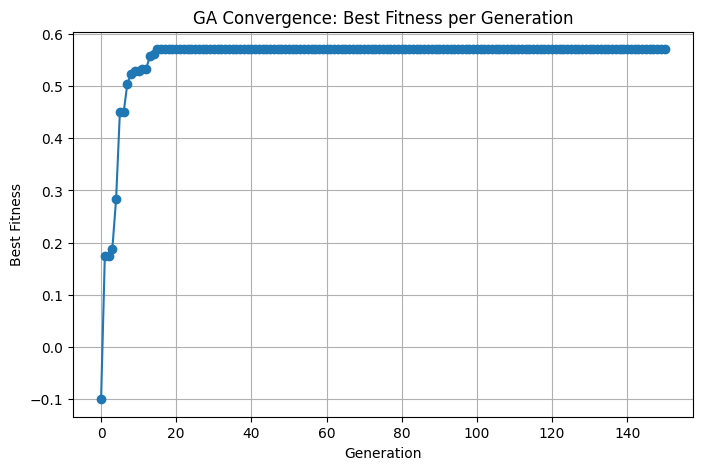

In [ ]:
import matplotlib.pyplot as plt

generations = list(range(len(history_best)))

plt.figure(figsize=(8, 5))
plt.plot(generations, history_best, marker='o')
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("GA Convergence: Best Fitness per Generation")
plt.grid(True)
plt.show()


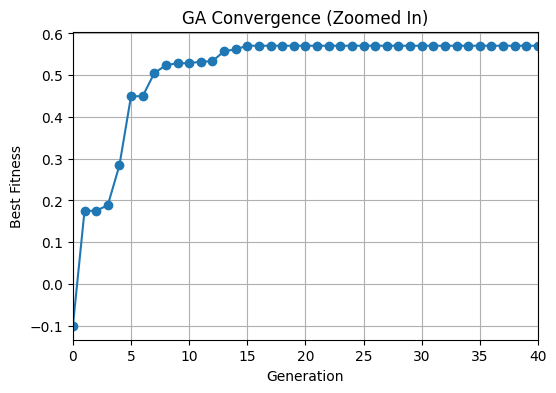

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(generations, history_best, marker='o')
plt.xlim(0, 40)  # zoom in on the first 40 generations where change happens
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("GA Convergence (Zoomed In)")
plt.grid(True)
plt.show()
